# Raster Calculations
### Question
* How can I do calculations in a raster?
### Objectives
* Perform operations with two rasters using python math operation
* Reclassify Rsater

## NDVI Calculation
NDVI = (NIR-Red)/(NIR+Red)              <br>          *It ranges from -1 to +1*

### 01 Loading Data

In [1]:
import pystac
import rioxarray
import geopandas as gpd

In [2]:
dir = "../Data/01_search.json"
items = pystac.ItemCollection.from_file(dir)
items

In [4]:
red_uri = items[1].assets["red"].href                        ## href - has the link for accessing data
nir_uri = items[1].assets["nir"].href

In [5]:
red = rioxarray.open_rasterio(red_uri, masked = True)        ## Masked = True for disregarding No_Data Values
nir = rioxarray.open_rasterio(nir_uri, masked = True)

In [7]:
red

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
[120560400 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    scale_factor:        1.0
    add_offset:          0.0

In [8]:
#clip to smaller extent
bbox = (629_000, 5_804_000, 639_000, 5_814_000)

In [9]:
red_clip = red.rio.clip_box(*bbox)
nir_clip = nir.rio.clip_box(*bbox)

In [12]:
red_clip.shape
nir_clip.shape

(1, 1000, 1000)

### 02 Plotting with Visual Enhancement
"Robust = True" does the visual enhancement by streching the histogram by disregarding lower and higher 2% pixels

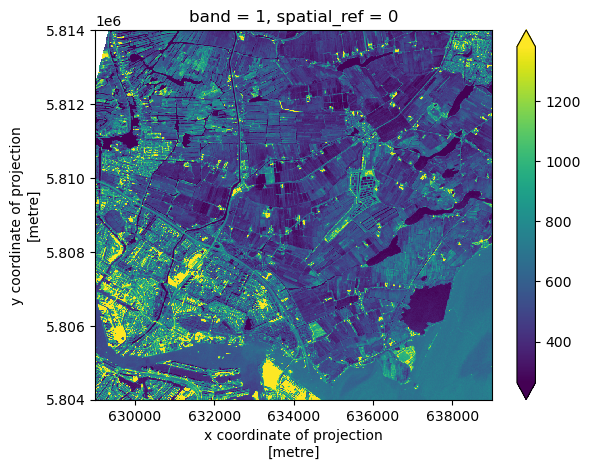

In [13]:
red_clip.plot(robust=True)

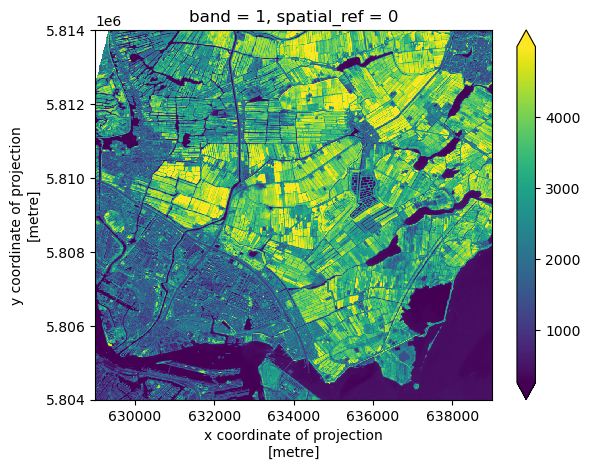

In [16]:
nir_clip.plot(robust=True)

### 03 Calculating NDVI
For band operations, we need to make sure selected bands have same *crs* and same *shape*

In [17]:
ndvi = (nir_clip-red_clip)/(nir_clip+red_clip)

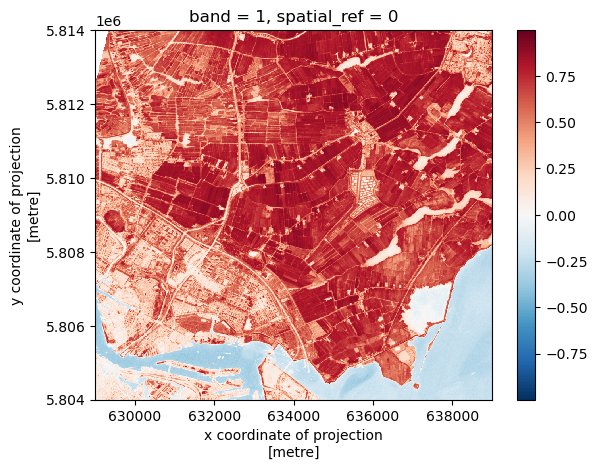

In [27]:
ndvi.plot()

In [25]:
# from matplotlib import colormaps
# list(colormaps)

(array([2.00000e+00, 3.00000e+00, 5.22840e+04, 6.34260e+04, 4.27830e+04,
        1.02270e+05, 1.11679e+05, 1.83683e+05, 3.29304e+05, 1.12138e+05]),
 array([-0.77932316, -0.6015507 , -0.42377827, -0.24600583, -0.06823339,
         0.10953906,  0.28731149,  0.46508396,  0.64285642,  0.82062882,
         0.99840128]),
 <BarContainer object of 10 artists>)

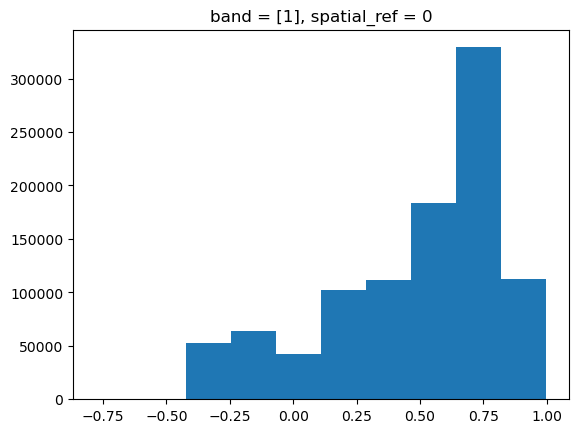

In [28]:
ndvi.plot.hist()

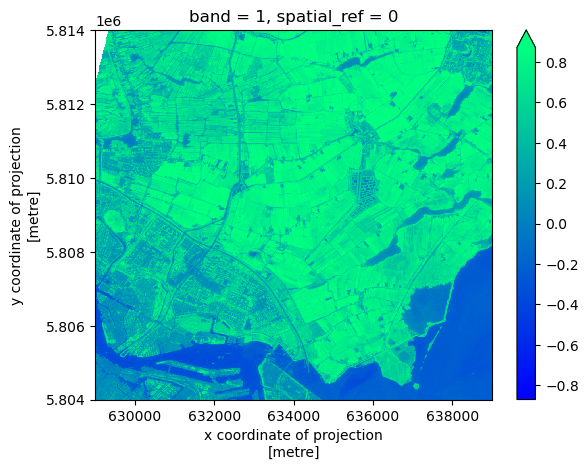

In [29]:
ndvi.plot(robust=True, cmap = "winter")

## 04 Excercise

** Min Max
** Histogram

In [43]:
ndvi.min().values.item()

-0.779323160648346

In [44]:
ndvi.max().values.item()

0.9984012842178345

In [49]:
ndvi.isnull().sum()

<xarray.DataArray ()>
array(2428)
Coordinates:
    spatial_ref  int32 0

In [55]:
# import matplotlib
# matplotlib.pyplot.hist?

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        8.0000e+00, 7.0000e+01, 5.5900e+02, 2.4690e+03, 5.1410e+03,
        6.5210e+03, 5.8700e+03, 7.3700e+03, 8.7590e+03, 1.5517e+04,
        2.0851e+04, 1.6596e+04, 1.0715e+04, 4.9400e+03, 2.2650e+03,
        1.4620e+03, 1.2600e+03, 1.3400e+03, 1.7930e+03, 2.2040e+03,
        2.2670e+03, 2.3470e+03, 2.4630e+03, 2.4380e+03, 2.8080e+03,
        3.1640e+03, 4.4680e+03, 5.8840e+03, 8.0170e+03, 8.9270e+03,
        9.4810e+03, 9.8510e+03, 1.0148e+04, 1.0179e+04, 1.0598e+04,
        1.0226e+04, 1.0364e+04, 1.0569e+04, 1.0414e+04, 1.0440e+04,
        1.0564e+04, 1.0541e+04, 1.0460e+04, 1.0671e+04, 1.0643e+04,
        1.0949e+04, 1.1154e+04, 1.1668e+04, 1.2255e+04, 1.2774e+04,
        1.3491e+04, 1.4519e+04, 1.5548e+04, 1.67

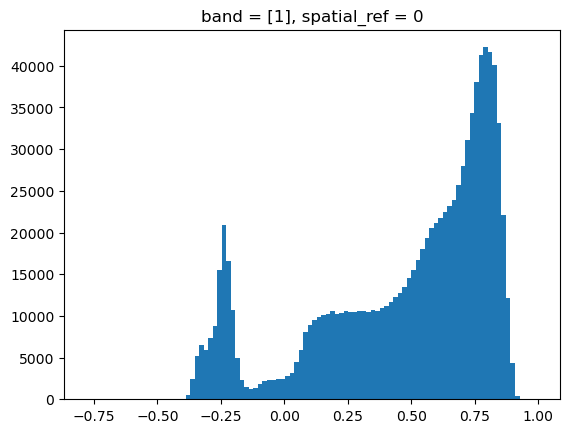

In [53]:
ndvi.plot.hist(bins=100)

#### Reclassify the raster in different classes
-1  - NDVI -  0 <br>
0 - NDVI - 0.2 <br>
0.2 - NDVI - 0.7 <br>
0.7 - NDVI - 1 

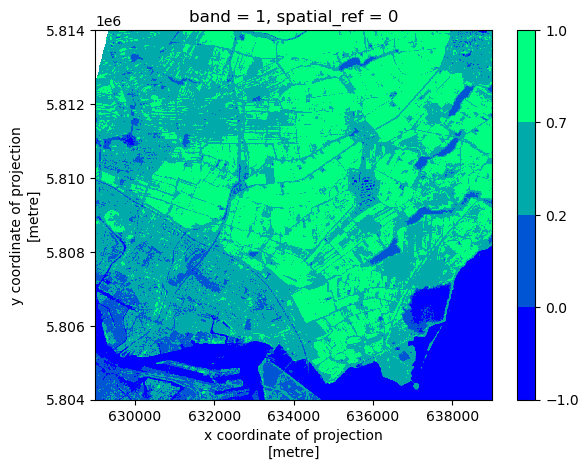

In [56]:
class_bins = [-1,0,0.2,0.7,1]
ndvi.plot(levels=class_bins,cmap="winter")

In [58]:
#interpolate nodata values
ndvi_nonan = ndvi.interpolate_na(dim='x')

In [59]:
# Save file
ndvi_nonan.rio.to_raster("../Data/05_ndvi.tif")

In [62]:
import numpy as np
import xarray

In [73]:
class_bins = [-1, 0., 0.2, 0.7, 1]

In [74]:
ndvi_classified = xarray.apply_ufunc(
    np.digitize,
    ndvi_nonan,
    class_bins
)

In [75]:
ndvi_classified.values

array([[[5, 5, 5, ..., 3, 3, 3],
        [5, 5, 5, ..., 3, 3, 3],
        [5, 5, 5, ..., 3, 3, 3],
        ...,
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1]]], dtype=int64)

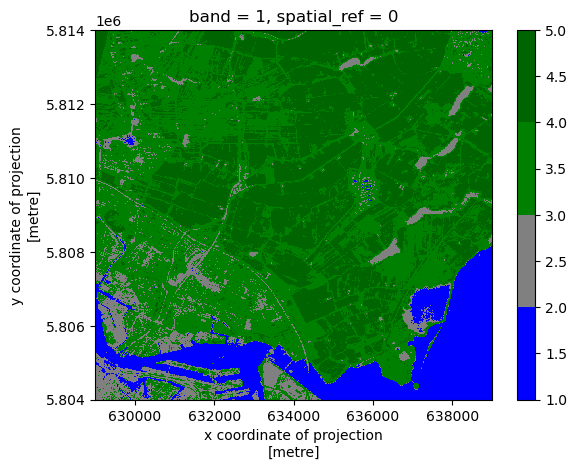

In [76]:
from matplotlib.colors import ListedColormap

ndvi_colors = ["blue","gray","green","darkgreen"]
ndvi_cmap = ListedColormap(ndvi_colors)
ndvi_classified.plot(cmap=ndvi_cmap)

In [79]:
ndvi_classified.rio.to_raster("../Data/05_ndvi_classified.tif")